In [9]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import Series, ExcelWriter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import random
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression,  ElasticNet, Ridge
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve, f1_score
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.model_selection import cross_validate, ShuffleSplit, learning_curve
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import warnings
from sklearn.ensemble import AdaBoostClassifier
warnings.filterwarnings("ignore")
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import NuSVC
import xlwt
from openpyxl import load_workbook
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_rows', 1000)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.datasets import make_regression
import random
pd.options.display.float_format = '{:.4f}'.format

dframe = pd.read_excel('data4Test.xlsx', skiprows = 3)
dframe = dframe.drop(dframe.index[0])
dframe = dframe.dropna(subset = ['CRUD LN Equity']).drop([1]).reset_index(drop = True).rename(columns = {'Unnamed: 0': 'DATE'})
original_col_list = list(dframe.columns[1:])


print(dframe.head(10))


                  DATE SX7E Index CRUD LN Equity F90503M Index F90502Y Index  \
0  2006-09-28 00:00:00   423.6400        42.5000        3.2880        3.5580   
1  2006-09-29 00:00:00   424.3800        41.4500        3.3050        3.5830   
2  2006-10-02 00:00:00   423.9000        41.1900        3.3250        3.6080   
3  2006-10-03 00:00:00   422.5800        39.6100        3.3410        3.6350   
4  2006-10-04 00:00:00   429.0100        39.0800        3.3590        3.5820   
5  2006-10-05 00:00:00   433.1200        40.2700        3.3410        3.5890   
6  2006-10-06 00:00:00   433.8500        39.5900        3.3470        3.6060   
7  2006-10-09 00:00:00   434.6200        40.6100        3.3550        3.6280   
8  2006-10-10 00:00:00   438.6200        39.6200        3.3680        3.6790   
9  2006-10-11 00:00:00   437.4600        39.3900        3.3790        3.6770   

  F90505Y Index F90510Y Index SPX Index DXY Curncy INDU Index    ...      \
0        3.7690        4.0190 1339.1500    

In [10]:
#Differences between interst curves

dframe['own_2Y_3M'] = dframe['F90502Y Index'] - dframe['F90503M Index']
dframe['own_5Y_2Y'] = dframe['F90505Y Index'] - dframe['F90502Y Index']
dframe['own_10Y_5Y'] = dframe['F90510Y Index'] - dframe['F90505Y Index']

#Other linear manipulation

dframe['own_SPX_DXY'] = dframe['SPX Index'] / dframe['DXY Curncy']

#If we want to use polynomial interations of the features:

dframe['own_CRUD^2'] = dframe['CRUD LN Equity'] ** 2
dframe['own_SX7E_CRUD'] = dframe['SX7E Index'] * dframe['CRUD LN Equity']
dframe.head()

# log-returns for equities and equity likes
log_df = pd.DataFrame()
log_df['DATE'] = dframe['DATE']
for i in dframe.drop(
        ['F90503M Index', 'F90502Y Index', 'F90505Y Index', 'F90510Y Index', 'own_2Y_3M', 'own_5Y_2Y', 'own_10Y_5Y'],
        axis=1).columns[1:]:
    try:
        log_df[i] = np.log(np.array(dframe[i] / dframe[i].shift(1), dtype=np.float32))
    except:
        log_df[i] = np.log(np.array(dframe[i], dtype=np.float32)) - np.log(np.array(dframe[i].shift(1), dtype=np.float32))


# simple returns for rates
df = pd.DataFrame()
df['DATE'] = dframe['DATE']
for i in dframe[['F90503M Index', 'F90502Y Index', 'F90505Y Index', 'F90510Y Index', 'own_2Y_3M', 'own_5Y_2Y',
             'own_10Y_5Y']].columns:
    # df[i] = (dframe[i] - dframe[i].shift(1))/100 # diff in rates
    df[i] = (dframe[i]) / 100 # rates

log_df = log_df.fillna(0)
df = df.fillna(0)

allData = pd.merge(df,log_df, on='DATE',how='left') # <<<<==== my starting dataset
del log_df, df # clean up memory



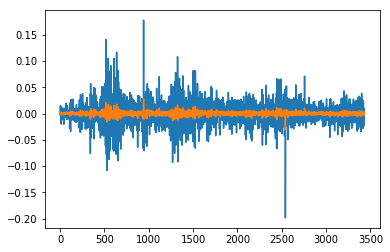

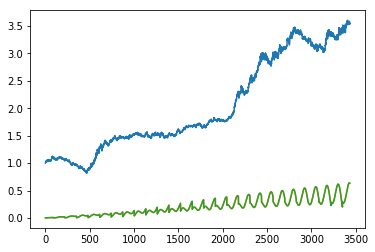

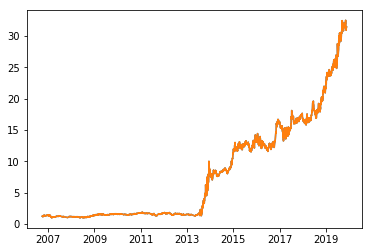

In [52]:
# *********************************************************************************************************************
# Generate an artificial price process made up of the terms detailed below

crudeB = -0.4
crudeAR = 0.1
crude2B = 0.3
crude2AR = 0.30
spxB = 0.15
spxAR = -0.02
sx7eB = 0.15
sx7eAR = -0.02
mixedB = 0.60
r2yrB = 0.70
r5yrB = 1
r10yrB = 0.30

alpha = 0.94
beta = 0.055

T = 1 # stands for one year
tradingDaysNo = 252
dt = T/tradingDaysNo
L = allData.shape[0] # of years in my historical timeseries


a = 0.05 # fixed time trend coefficient

TT = np.zeros([L,2])
mu_crude = np.zeros([L,1])
mu_crude2 = np.zeros([L,1])
mu_spx = np.zeros([L,1])
mu_sx7e = np.zeros([L,1])
mu_mixed = np.zeros([L,1])
rate_1 = np.zeros([L,1])
rate_2 = np.zeros([L,1])
bondPrice = np.ones([L,1])
equityPrice = np.ones([L,1])
variance = np.zeros([L,1])
sigma = np.zeros([L,1])
e = np.zeros([L,1])

# garch parameters
desiredAnnualisedLongTermSigma = 0.30;  # this number won't be achieved because of the GARCH dynamics itself !!!
LongTermVariance = (desiredAnnualisedLongTermSigma**2)*dt  # get single unit of time long term variance % see note below
V0 = LongTermVariance
alpha = 0.80
beta = 0.19;
gamma = (1 - alpha - beta);
omega = gamma * LongTermVariance;

dP = np.zeros([L,1])
S0 = 1 # initial stock price
random.seed(999) # for reproducibility

for k in range(0,L):
    t = k + 1 # time index
    yf = t / tradingDaysNo

    # 1) time trend with seasonal component
    seas_sign = 1 if allData['DATE'][k].month in range(2,8) else -1
    TT[k] = a*yf/2 + a*yf/4 * (np.sin(4 * np.pi * yf)) + a*yf/4*np.cos(2 * np.pi * yf)*seas_sign
    
    
    # DRIFTS FOR THE EQUITY LIKE TERM
    # 2) drifts from:
    # crude
    mu_crude[k] = crudeB*allData['CRUD LN Equity'][k] if t==1 else crudeB*allData['CRUD LN Equity'][k]  +  crudeAR*allData['CRUD LN Equity'][k-1]
    # crude squared
    mu_crude2[k] = crude2B * allData['CRUD LN Equity'][k]**2 if t == 1 else crude2B * allData['CRUD LN Equity'][k]**2 + crude2AR*allData['CRUD LN Equity'][k-1]**2
    # SPX
    mu_spx[k] = spxB * allData['SPX Index'][k] if t == 1 else spxB * allData['SPX Index'][k] + spxAR * allData['SPX Index'][k - 1]
    # SX7E
    mu_sx7e[k] = sx7eB * allData['SX7E Index'][k] if t == 1 else sx7eB * allData['SX7E Index'][k] + sx7eAR * allData['SX7E Index'][k - 1]
    # mixed spx*crude/dxy
    mu_mixed[k] = mixedB * allData['SPX Index'][k] * allData['CRUD LN Equity'][k] / allData['DXY Curncy'][k]

    dP[k] = mu_crude[k] + mu_crude2[k] + mu_spx[k] + mu_sx7e[k]

    # DRIFTS FOR THE BOND TERM + Bond Price
    # 2) allData
    rate_1[k] = r10yrB*allData['F90510Y Index'][k] - r2yrB*allData['F90502Y Index'][k]
    rate_2[k] = r5yrB * allData['F90505Y Index'][k]
    bondPrice[k] = np.exp(-(rate_1[k] + rate_2[k]) * ((L - t) / 365))

    # 3) global diffusion term
    # sigma[k] = sigma0 + alpha*sigma[k-1] + (beta*np.random.normal(0,1))*np.sqrt(dt)
    # deps[k]
    z = random.normalvariate(0, 1)
    variance[k] = V0 if t == 1 else ((omega + alpha*variance[k-1] + beta*e[k-1]**2))
    e[k] =  variance[k]**0.5 * z if t == 1 else variance[k]**0.5 * z
    sigma[k] = 0 if t==1 else variance[k] **0.5
    # equity and bond pricing
    equityPrice[k] = equityPrice[k - 1] * np.exp(dP[k] + sigma[k]*random.normalvariate(0, 1)) if t > 1 else S0 * np.exp(dP[k])
    bondPrice[k] = np.exp(-(rate_1[k] + rate_2[k]) * ((L - t) / 365))

dates = np.array(allData['DATE'])
Price = TT + equityPrice/bondPrice # get the final artificial price using the bond price as a numeraire and adding the time trend

plt.figure()
plt.plot(allData['SX7E Index'])
plt.plot(mu_sx7e)

plt.figure()
plt.plot(np.exp(np.cumsum(dP)))
plt.plot(TT)
plt.show()


plt.figure()
plt.plot(dates, Price, label = 'Artificial Price')
plt.show()